# Формироване обучающей выборки

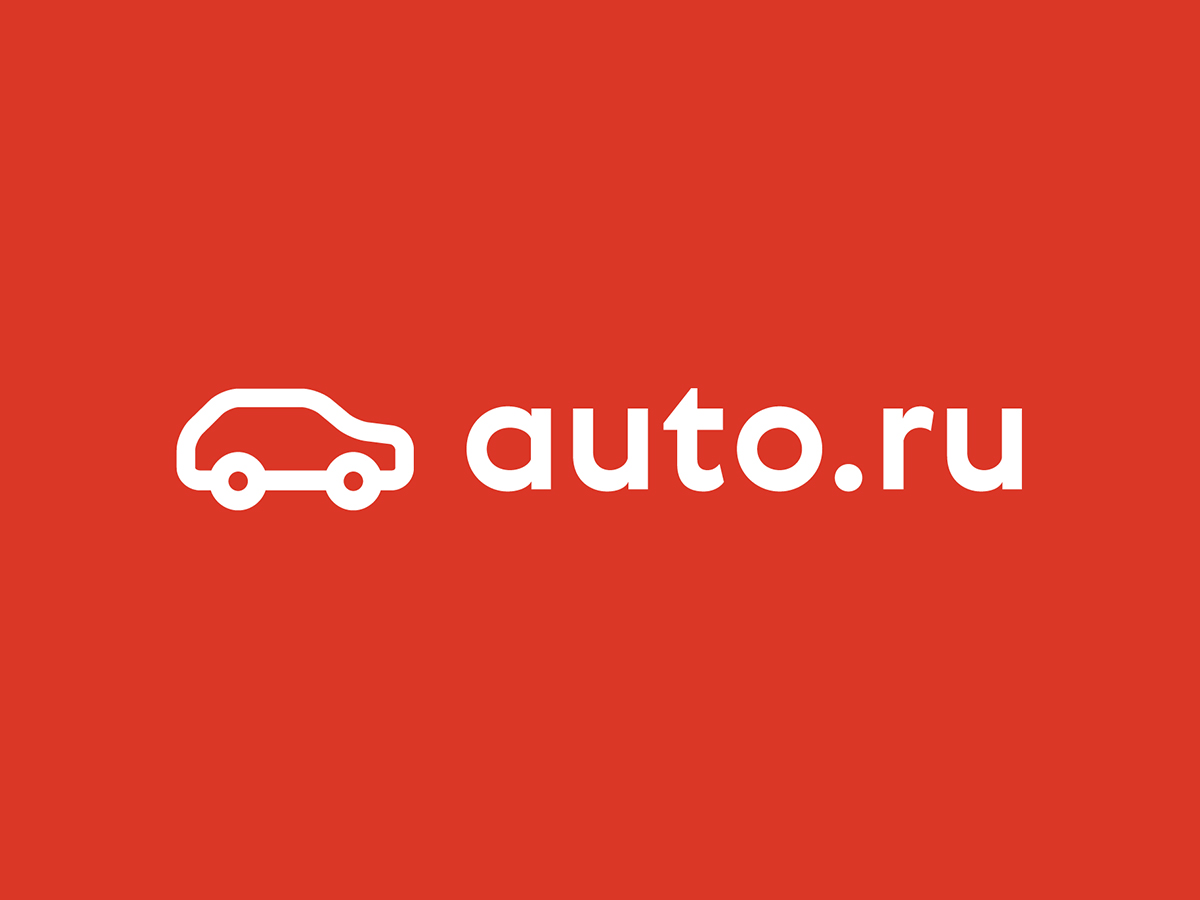

Представим, что мы работаете в компании, которая занимается продажей автомобилей с пробегом. Основная задача компании и ее менеджеров - максимально быстро находить выгодные предложения (проще говоря, купить ниже рынка, а продать дороже рынка).

Перед нами стоит задача создать модель, которая будет предсказывать стоимость автомобиля по его характеристикам.
Так вышло, что объем датасета, представленного самой компании недостаточен для того, чтобы провести грамотный анализ, поэтому было принято решение воспользоваться данными с сайта auto.ru

Для формирование обучающей выборки воспользуемся технологией веб-скрейпинга. Для этого нам нужно найти карту сайта. Для этого обратимся к файлу /robots.txt, добавив эту строку к адресу сайта

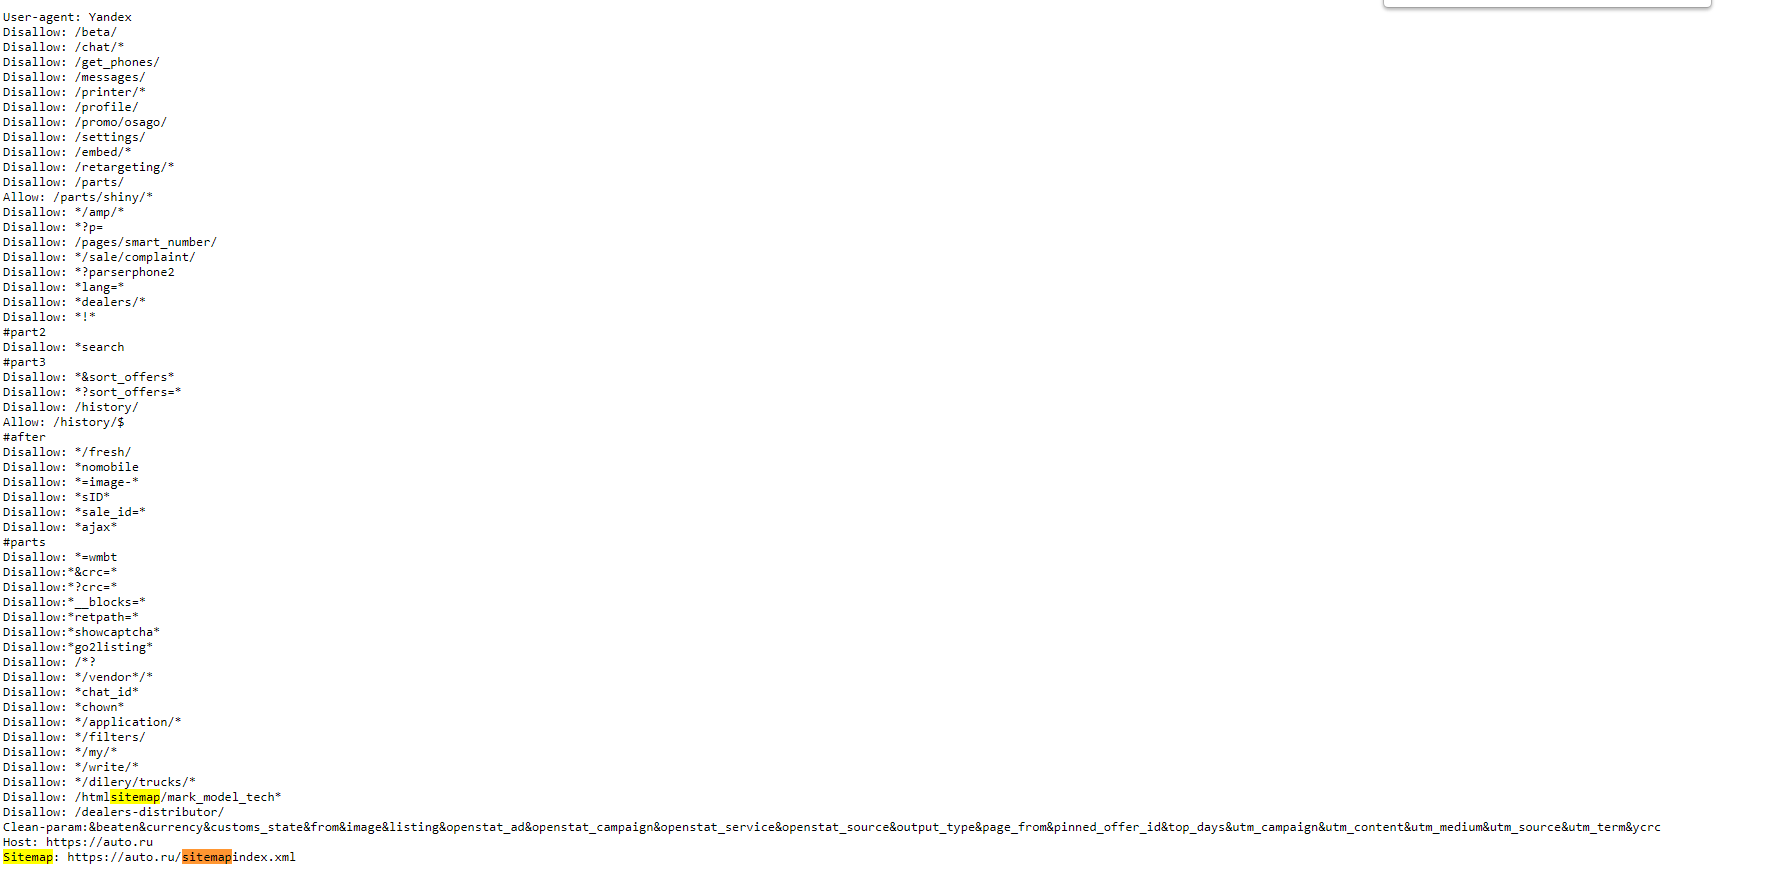

В указанном файле находится ссылка на искомую информацию, то есть карта сайта находится по адресу: https://auto.ru/sitemapindex.xml

In [1]:
import requests
import sys
import gzip
import csv
import os
import pandas as pd
from tempfile import TemporaryDirectory 
from pathlib import Path, PurePath
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
import requests

import numpy as np 
import pandas as pd 

import json
import dataprep.eda
import datetime
import seaborn as sns
import warnings
import matplotlib.pyplot as plt

import pandas as pd
from pandas import Series
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import mean_squared_error
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from catboost import CatBoostRegressor

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


In [2]:
output = Path('.').resolve().parents[0].joinpath('input', 'links.csv')
sitemap_link='https://auto.ru/sitemapindex.xml'

In [3]:
temp_fold = TemporaryDirectory()
temp_path = Path(temp_fold.name)
r = requests.get(sitemap_link)
text = r.content.decode()
soup = BeautifulSoup(text, 'lxml')
links_to_gz = []
i = 0
for element in soup.find_all('loc'):
    links_to_gz.append(element.text.strip())
    i += 1
print(f'Found {i} link lists as gzipped xml files.')

Found 50 link lists as gzipped xml files.


In [4]:
offers_cars = [x for x in links_to_gz if 'offers_cars' in x]

In [5]:
i=0
for link in tqdm(offers_cars):
    tempfile = temp_path / link.split('/')[-1]
    if not tempfile.is_file():
        r = requests.get(link, allow_redirects=True)
        with tempfile.open('wb') as file:
            file.write(r.content)
        i+=1
print(f'Downloaded {i} link files')

  0%|          | 0/8 [00:00<?, ?it/s]

Downloaded 8 link files


In [6]:
i = 0
for gz in tqdm(list(temp_path.iterdir())):
    gz = gz.resolve()
    if gz.suffix == '.gz':
        with gzip.open(gz) as archive:
            with open(gz.parent / gz.stem, 'wb') as output_file:
                output_file.write(archive.read())
        gz.unlink()
    i += 1
print(f'Unzipped {i} txt files.')

  0%|          | 0/8 [00:00<?, ?it/s]

Unzipped 8 txt files.


In [7]:
offers_list = []
for txt in tqdm(list(temp_path.iterdir())):
    offers_counter = 0
    with open(txt, 'r') as f:
        file_content = f.read().splitlines()
        offers_list += file_content
        print(f'Found {len(file_content)} links in file {txt}, totally {len(offers_list)} links')
# write this list to csv
output_path = Path(output).resolve()
with output_path.open('w+', newline='') as f:
    wr = csv.writer(f)
    for line in offers_list:
        wr.writerow([line])
print(f'Output written to file {str(output_path)}')
# cleanup temp folder
temp_fold.cleanup()


  0%|          | 0/8 [00:00<?, ?it/s]

Found 50000 links in file C:\Users\kozle\AppData\Local\Temp\tmpf3eeyb43\sitemap_offers_cars_1.txt, totally 50000 links
Found 50000 links in file C:\Users\kozle\AppData\Local\Temp\tmpf3eeyb43\sitemap_offers_cars_2.txt, totally 100000 links
Found 50000 links in file C:\Users\kozle\AppData\Local\Temp\tmpf3eeyb43\sitemap_offers_cars_3.txt, totally 150000 links
Found 50000 links in file C:\Users\kozle\AppData\Local\Temp\tmpf3eeyb43\sitemap_offers_cars_4.txt, totally 200000 links
Found 50000 links in file C:\Users\kozle\AppData\Local\Temp\tmpf3eeyb43\sitemap_offers_cars_5.txt, totally 250000 links
Found 50000 links in file C:\Users\kozle\AppData\Local\Temp\tmpf3eeyb43\sitemap_offers_cars_6.txt, totally 300000 links
Found 50000 links in file C:\Users\kozle\AppData\Local\Temp\tmpf3eeyb43\sitemap_offers_cars_7.txt, totally 350000 links
Found 42023 links in file C:\Users\kozle\AppData\Local\Temp\tmpf3eeyb43\sitemap_offers_cars_8.txt, totally 392023 links
Output written to file C:\Users\kozle\inp

Мы получили ссылки, по которым можно формировать датасет

In [8]:
links=pd.read_csv('links.csv')

In [9]:
links

https://auto.ru/cars/used/sale/daewoo/nexia/1019666047-bfc0d/
0       https://auto.ru/cars/used/sale/volkswagen/tran...           
1       https://auto.ru/cars/used/sale/toyota/land_cru...           
2       https://auto.ru/cars/used/sale/mitsubishi/mira...           
3       https://auto.ru/cars/used/sale/ford/fusion/108...           
4       https://auto.ru/cars/used/sale/great_wall/hove...           
...                                                   ...           
400259  https://auto.ru/cars/used/sale/ford/explorer/1...           
400260  https://auto.ru/cars/used/sale/audi/a6/1102947...           
400261  https://auto.ru/cars/new/group/hyundai/solaris...           
400262  https://auto.ru/cars/new/group/vaz/granta/2137...           
400263  https://auto.ru/cars/new/group/vaz/granta/2137...           

[400264 rows x 1 columns]

Посмотрим, какие признаки есть в исходном датасете, чтобы новый датасет был эквивалентен старому
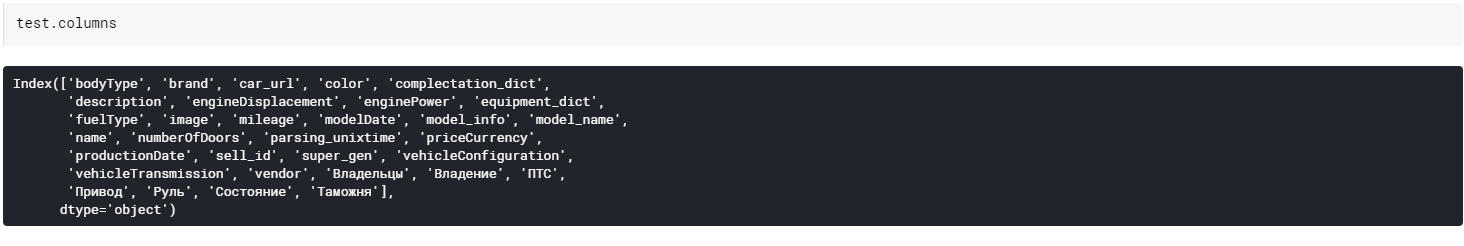

In [10]:
train=pd.read_csv('New_dataset.csv', usecols = lambda x: x not in ('photos_links', 'descr'))
test=pd.read_csv('test.csv')

In [11]:
train=train

# Сравнение и упорядочивание двух выборок

  0%|          | 0/345 [00:00<?, ?it/s]


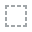
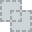
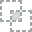
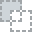
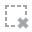
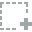
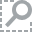
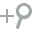
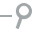
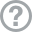
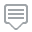
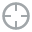
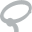
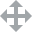
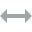
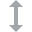
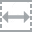
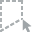
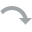
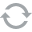
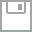
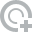
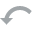
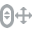
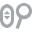
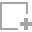
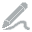
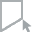
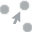
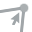
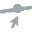

In [12]:
dataprep.eda.plot_missing(test)

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

## Колонка BodyType или body_type

In [14]:
test.bodyType.value_counts()
test.bodyType.isna().value_counts()

False    34686
Name: bodyType, dtype: int64

In [15]:
train.body_type.isna().value_counts()
# колонки похожи и идентичны, в  обучающей выборке всего 7 пропусков, удалим.

False    332647
True         29
Name: body_type, dtype: int64

In [16]:
train=train.dropna(subset=['body_type'],axis=0)

In [17]:
#переименуем колонку
test=test.rename({'bodyType': 'body_type'}, axis=1)

In [18]:
#Создадим новый датафрейм, в котором колонки будут идти в том же порядке, что и в тесте
new_train=pd.DataFrame(train['body_type'])
new_train

body_type
0           хэтчбек 5 дв.
1                   седан
2                   седан
3                   седан
4                   седан
...                   ...
332671  внедорожник 5 дв.
332672  внедорожник 5 дв.
332673  внедорожник 5 дв.
332674              седан
332675    универсал 5 дв.

[332647 rows x 1 columns]

In [19]:
dummies=[]
dummies.append('body_type')

## Колонка Brand

In [20]:
test.brand.value_counts()
# Эту колонку нужно будет преобразовать при помощи Get_dymmies, и сделать их все строчными

BMW           4473
VOLKSWAGEN    4404
NISSAN        4393
MERCEDES      4180
TOYOTA        3913
AUDI          3421
MITSUBISHI    2843
SKODA         2741
VOLVO         1463
HONDA         1150
INFINITI       871
LEXUS          834
Name: brand, dtype: int64

In [21]:
brands=[]
for brand in test.brand:
    brands.append(brand.lower())
test.brand=brands
test.brand

0        skoda
1        skoda
2        skoda
3        skoda
4        skoda
         ...  
34681      bmw
34682      bmw
34683      bmw
34684      bmw
34685      bmw
Name: brand, Length: 34686, dtype: object

In [22]:
train.brand.value_counts()
train.brand.isna().value_counts()
#машин гораздо больше, не знаю, насколько это важно конкретно для нашей задачи, но пусть будет, унифицируем, удалим пропуски их всего 22

False    332647
Name: brand, dtype: int64

In [23]:
train=train.dropna(subset=['brand'],axis=0)
brands=[]
for brand in train.brand:
    brands.append(brand.lower())
train.brand=brands
train.brand

0             toyota
1         lada (ваз)
2             daewoo
3          chevrolet
4          chevrolet
             ...    
332671        suzuki
332672           bmw
332673        nissan
332674       citroen
332675    lada (ваз)
Name: brand, Length: 332647, dtype: object

In [24]:
#Заменим на числа топ 12 брендов из теста
brands=[]
for brand in train.brand:
    if brand == 'bmw':
        brands.append(1)
    elif brand == 'volkswagen':
        brands.append(2)
    elif brand == 'nissan':
        brands.append(3)
    elif brand == 'mercedes':
        brands.append(4)
    elif brand == 'toyota':
        brands.append(5)
    elif brand == 'audi':
        brands.append(6)
    elif brand == 'mitsubishi':
        brands.append(7)
    elif brand == 'skoda':
        brands.append(8)
    elif brand == 'volvo':
        brands.append(9)
    elif brand == 'honda':
        brands.append(10)
    elif brand == 'infiniti':
        brands.append(11)
    elif brand == 'lexus':
        brands.append(12)
    else:
        brands.append(0)
train.brand=brands

In [25]:
brands=[]
for brand in test.brand:
    if brand == 'bmw':
        brands.append(1)
    elif brand == 'volkswagen':
        brands.append(2)
    elif brand == 'nissan':
        brands.append(3)
    elif brand == 'mercedes':
        brands.append(4)
    elif brand == 'toyota':
        brands.append(5)
    elif brand == 'audi':
        brands.append(6)
    elif brand == 'mitsubishi':
        brands.append(7)
    elif brand == 'skoda':
        brands.append(8)
    elif brand == 'volvo':
        brands.append(9)
    elif brand == 'honda':
        brands.append(10)
    elif brand == 'infiniti':
        brands.append(11)
    elif brand == 'lexus':
        brands.append(12)
    else:
        brands.append(0)
test.brand=brands

In [26]:
new_train['brand']=train.brand

In [27]:
dummies.append('brand')

## Колонка color 

In [28]:
train.color.value_counts()

чёрный         69176
белый          67556
серебристый    50268
серый          41854
синий          29755
красный        19552
зелёный        17723
коричневый     11762
бежевый         6786
голубой         5504
золотистый      3283
фиолетовый      2781
пурпурный       2687
жёлтый          1939
оранжевый       1853
розовый          168
Name: color, dtype: int64

In [29]:
test.color.value_counts()
#цвета одинаковые, записаны одинаково, проверим train  на пропуски и идем дальше

чёрный         11010
белый           6133
серебристый     4113
серый           3984
синий           3289
красный         1531
коричневый      1501
зелёный          952
бежевый          639
голубой          457
золотистый       266
пурпурный        254
фиолетовый       219
жёлтый           194
оранжевый        131
розовый           13
Name: color, dtype: int64

In [30]:
train.color.isna().value_counts()
#пропусков нет, берем целиком, позднее сделаем dummies

False    332647
Name: color, dtype: int64

In [31]:
new_train['color']=train.color

In [32]:
dummies.append('color')

## Колонка complectation_dict 

In [33]:
test=test.drop(columns=['complectation_dict'])

## Колонка description или complectation

In [34]:
#Переимениую, чтобы не путаться
test=test.rename({'description': 'complectation'}, axis=1)

In [35]:
# Для начала сделаем столбик, в котором будет записана длина сообщения. Некоторые из них совсем короткие, некоторые длинные
# Может быть это имеет значение

In [36]:
leng=[]
for comp in test.complectation:
    leng.append(len(comp))

test['complectation_len']=leng

In [37]:
#Пропусков очень много, заполним их. Отсутствие информации в данном случае тоже информация.Заменим пустые значение на "Noinfo"
train.complectation.isna().value_counts()

False    183059
True     149588
Name: complectation, dtype: int64

In [38]:
train.complectation=train.complectation.fillna(value = 'Noinfo')

In [39]:
leng=[]
for comp in train.complectation:
    if comp != 'Noinfo':
        leng.append(len(comp))
    else:
        leng.append(0)
train['complectation_len']=leng

In [40]:
# Поскольку строчка эта довольно творческая и в целом каждый продавец нахваливает свой автомобиль как хочет,я попробую вычленить 
#из этой строчки ключевые слова. Сначала унифицируем списки)
compl=[]
for comp in test.complectation:
    compl.append(comp.replace('\n—', '••').replace('\n • ', '••').replace('\n•', '••')
                 .replace('\n✔', '••').replace('\n►', '••').replace('\n➥', '••').replace('\n    •', '••')
                 .replace('\n   ✔', '••').replace('✪', '••').replace('\n☛', '••').replace(', ', '••').replace('\n✅ ', '••')
                 .replace('\n☑️ ', '••').replace('\n▶', '••').replace('\n   ✔', '••').replace('\n*', '••').replace('# ', '••'))

   

In [41]:
#Выделяем ключевые слова, возьмем пока топ 30
compl=str(compl)
key_words=pd.DataFrame(compl.split(sep= '••'),columns=['complectation']) # превращаем строку в датафрейм
key_words_list=key_words.complectation.value_counts().head(50)

In [42]:
key_words_list=list(key_words_list.index)
key_words_list.append('Noinfo')

In [43]:
k_list=[]
for key in key_words_list:
    k_list.append(key.strip())
k_list

['Центральный замок',
 'Антиблокировочная система',
 'Бортовой компьютер',
 'Электропривод зеркал',
 'Обогрев зеркал',
 'CD',
 'Система курсовой устойчивости',
 'Подушки безопасности водителя',
 'Иммобилайзер',
 'Датчик света',
 'Противотуманные фары',
 'Литые легкосплавные диски',
 'Электростеклоподъемники передние и задние',
 'Датчик дождя',
 'Темный салон',
 'Подушки безопасности пассажира',
 'Круиз-контроль',
 'Подогрев сидений водителя и пассажира',
 'Боковые передние подушки безопасности',
 'Система крепления детских автокресел Isofix / LATCH',
 'Тканевая обивка салона',
 'Парктроник передний и задний',
 'Кожаная обивка салона',
 'Кожаный руль',
 'Bluetooth',
 'Климат-контроль 2-зонный',
 'Гидро усилитель руля',
 'Кондиционер',
 'Мультифункциональное рулевое колесо',
 'Оконные шторки безопасности',
 'Страхование КАСКО',
 'AUX',
 'USB',
 'года выпуска',
 'Антипробуксовочная система',
 'Розетка 12V',
 'Складывающееся заднее сидение',
 'Камера заднего вида',
 'Передний центральный п

In [44]:
key_list=[]
keys_l=[]


for key in k_list:
    keys_l=[]
    for comp in train.complectation.head(10):
        if key in comp:
            keys_l.append(key)
    key_list.append(keys_l)
    

In [45]:
key_list=[]
keys_l=[]

for comp in test.complectation:
    keys_l=[]
    for key in k_list:
        if key in comp:
            keys_l.append(key)
    key_list.append(keys_l)
key_list

[['Первоначальный взнос от 0%;'],
 ['Центральный замок',
  'Антиблокировочная система',
  'Бортовой компьютер',
  'Электропривод зеркал',
  'Обогрев зеркал',
  'Система курсовой устойчивости',
  'Иммобилайзер',
  'Датчик света',
  'Противотуманные фары',
  'Датчик дождя',
  'Круиз-контроль',
  'USB',
  'Антипробуксовочная система',
  'Регулировка руля',
  'Усилитель руля'],
 ['Первоначальный взнос от 0%;'],
 ['Первоначальный взнос от 0%;'],
 ['Центральный замок',
  'Антиблокировочная система',
  'Бортовой компьютер',
  'Электропривод зеркал',
  'Обогрев зеркал',
  'CD',
  'Система курсовой устойчивости',
  'Иммобилайзер',
  'Датчик света',
  'Противотуманные фары',
  'Датчик дождя',
  'Круиз-контроль',
  'Антипробуксовочная система',
  'Регулировка руля',
  'Усилитель руля'],
 ['ПТС'],
 [],
 ['Центральный замок',
  'Антиблокировочная система',
  'Бортовой компьютер',
  'Электропривод зеркал',
  'Обогрев зеркал',
  'CD',
  'Иммобилайзер',
  'Датчик света',
  'Датчик дождя',
  'Кондицион

In [46]:
test['key_list']=key_list

In [47]:
dummies.append('key_list')

In [48]:
key_list=[]
keys_l=[]

for comp in train.complectation:
    keys_l=[]
    for key in k_list:
        if key in comp:
            keys_l.append(key)
    key_list.append(keys_l)
key_list

[['Noinfo'],
 ['Noinfo'],
 ['Центральный замок', 'Кондиционер', 'AUX', 'USB'],
 ['Центральный замок',
  'Антиблокировочная система',
  'Бортовой компьютер',
  'Иммобилайзер',
  'Bluetooth',
  'Кондиционер',
  'Мультифункциональное рулевое колесо',
  'USB',
  'Регулировка руля',
  'Третий задний подголовник',
  'Усилитель руля'],
 [],
 [],
 ['Датчик света',
  'Противотуманные фары',
  'Датчик дождя',
  'Круиз-контроль',
  'Bluetooth',
  'Мультифункциональное рулевое колесо',
  'AUX',
  'USB',
  'Розетка 12V'],
 [],
 ['Бортовой компьютер'],
 ['Noinfo'],
 ['Центральный замок',
  'Антиблокировочная система',
  'Бортовой компьютер',
  'Электропривод зеркал',
  'Датчик света',
  'Противотуманные фары',
  'Датчик дождя',
  'Круиз-контроль',
  'Bluetooth',
  'Климат-контроль 2-зонный',
  'Мультифункциональное рулевое колесо',
  'AUX',
  'USB',
  'Антипробуксовочная система',
  'Передний центральный подлокотник',
  'Регулировка руля',
  'Усилитель руля'],
 ['Центральный замок',
  'Антиблокирово

In [49]:
train['key_list']=key_list
new_train['key_list']=key_list

In [50]:
for feature in k_list:
    feature_column=[]
    for i in test.index:
        if feature in test.key_list.loc[i]:
            feature_column.append(1)
        else:
            feature_column.append(0)
    test[feature]=feature_column

In [51]:
for feature in k_list:
    feature_column=[]
    for i in new_train.index:
        if feature in new_train.key_list.loc[i]:
            feature_column.append(1)
        else:
            feature_column.append(0)
    new_train[feature]=feature_column


In [52]:
len(key_list)

332647

## Колонка engineDisplacement или engine_volume                                    

In [53]:
test=test.rename({'engineDisplacement': 'engine_volume'}, axis=1)

In [54]:
test.engine_volume.value_counts()
#обнаружилась проблема, 55 автовладельцев не указали объем двигателя

2.0 LTR    7391
1.6 LTR    4973
3.0 LTR    3915
1.8 LTR    3349
2.5 LTR    2477
2.4 LTR    1745
3.5 LTR    1710
1.4 LTR    1635
1.5 LTR     725
1.2 LTR     485
4.4 LTR     447
2.8 LTR     384
4.7 LTR     377
1.3 LTR     365
5.5 LTR     361
4.0 LTR     356
3.2 LTR     348
4.5 LTR     346
2.1 LTR     271
3.7 LTR     242
2.2 LTR     236
4.2 LTR     228
1.9 LTR     221
2.3 LTR     203
2.7 LTR     189
3.6 LTR     183
5.6 LTR     170
5.0 LTR     158
5.7 LTR     135
2.9 LTR     131
4.6 LTR     108
3.1 LTR      88
4.8 LTR      84
1.7 LTR      59
3.8 LTR      57
1.0 LTR      57
 LTR         55
2.6 LTR      55
0.7 LTR      53
6.0 LTR      53
3.3 LTR      44
3.4 LTR      36
4.1 LTR      35
4.3 LTR      32
5.4 LTR      31
6.2 LTR      28
5.9 LTR      12
5.2 LTR      12
6.3 LTR       8
5.8 LTR       7
6.6 LTR       6
1.1 LTR       4
4.9 LTR       4
5.3 LTR       1
3.9 LTR       1
Name: engine_volume, dtype: int64

In [55]:
test[test.engine_volume == ' LTR']
#Объем не указан потому что это электрокары, укажем 0 везде

body_type  brand  \
5241   внедорожник 5 дв.      6   
7992       хэтчбек 5 дв.      1   
8252       хэтчбек 5 дв.      1   
8350       хэтчбек 5 дв.      1   
8684       хэтчбек 5 дв.      1   
8722       хэтчбек 5 дв.      1   
8917       хэтчбек 5 дв.      1   
10817      хэтчбек 5 дв.      1   
10936      хэтчбек 5 дв.      1   
11043      хэтчбек 5 дв.      1   
11302      хэтчбек 5 дв.      3   
11682      хэтчбек 5 дв.      3   
11714      хэтчбек 5 дв.      3   
11719      хэтчбек 5 дв.      3   
11754      хэтчбек 5 дв.      3   
11878      хэтчбек 5 дв.      3   
11974      хэтчбек 5 дв.      3   
12072      хэтчбек 5 дв.      3   
12085      хэтчбек 5 дв.      3   
12100      хэтчбек 5 дв.      3   
12250      хэтчбек 5 дв.      3   
12287      хэтчбек 5 дв.      3   
12334      хэтчбек 5 дв.      3   
12466      хэтчбек 5 дв.      3   
12481      хэтчбек 5 дв.      3   
12558      хэтчбек 5 дв.      3   
12582      хэтчбек 5 дв.      3   
12678      хэтчбек 5 дв.      3   
12749      хэтчбек 5 дв.      3   
12854      хэтчбек 5 дв.      3   
12916      хэтчбек 5 дв.      3   
12948      хэтчбек 5 дв.      3   
12950      хэтчбек 5 дв.      3   
13052      хэтчбек 5 дв.      3   
13104      хэтчбек 5 дв.      3   
13105      хэтчбек 5 дв.      3   
13478      хэтчбек 5 дв.      3   
13633      хэтчбек 5 дв.      3   
13660      хэтчбек 5 дв.      3   
13720      хэтчбек 5 дв.      3   
13812      хэтчбек 5 дв.      3   
13915      хэтчбек 5 дв.      3   
13952      хэтчбек 5 дв.      3   
13989      хэтчбек 5 дв.      3   
14147      хэтчбек 5 дв.      3   
14419      хэтчбек 5 дв.      3   
23869      хэтчбек 5 дв.      2   
23948      хэтчбек 5 дв.      2   
27064      хэтчбек 5 дв.      7   
28241      хэтчбек 5 дв.      7   
32668      хэтчбек 5 дв.      3   
32700      хэтчбек 5 дв.      3   
32798      хэтчбек 5 дв.      3   
34159      хэтчбек 5 дв.      4   
34504      хэтчбек 5 дв.      3   

                                                 car_url        color  \
5241   https://auto.ru/cars/used/sale/audi/e_tron/110...        белый   
7992   https://auto.ru/cars/used/sale/bmw/i3/11010431...        синий   
8252   https://auto.ru/cars/used/sale/bmw/i3/11012780...        серый   
8350   https://auto.ru/cars/used/sale/bmw/i3/11002716...        белый   
8684   https://auto.ru/cars/used/sale/bmw/i3/11011745...       чёрный   
8722   https://auto.ru/cars/used/sale/bmw/i3/11000973...      голубой   
8917   https://auto.ru/cars/used/sale/bmw/i3/11008715...      бежевый   
10817  https://auto.ru/cars/used/sale/bmw/i3/11012664...        серый   
10936  https://auto.ru/cars/used/sale/bmw/i3/10996733...       чёрный   
11043  https://auto.ru/cars/used/sale/bmw/i3/10993761...        серый   
11302  https://auto.ru/cars/used/sale/nissan/leaf/110...      голубой   
11682  https://auto.ru/cars/used/sale/nissan/leaf/110...        белый   
11714  https://auto.ru/cars/used/sale/nissan/leaf/109...        белый   
11719  https://auto.ru/cars/used/sale/nissan/leaf/109...        белый   
11754  https://auto.ru/cars/used/sale/nissan/leaf/110...        белый   
11878  https://auto.ru/cars/used/sale/nissan/leaf/110...  серебристый   
11974  https://auto.ru/cars/used/sale/nissan/leaf/108...       чёрный   
12072  https://auto.ru/cars/used/sale/nissan/leaf/110...       чёрный   
12085  https://auto.ru/cars/used/sale/nissan/leaf/109...      голубой   
12100  https://auto.ru/cars/used/sale/nissan/leaf/109...        серый   
12250  https://auto.ru/cars/used/sale/nissan/leaf/109...        серый   
12287  https://auto.ru/cars/used/sale/nissan/leaf/109...      голубой   
12334  https://auto.ru/cars/used/sale/nissan/leaf/110...       чёрный   
12466  https://auto.ru/cars/used/sale/nissan/leaf/110...       чёрный   
12481  https://auto.ru/cars/used/sale/nissan/leaf/110...        белый   
12558  https://auto.ru/cars/used/sale/nissan/leaf/109...  серебристый   
12582  https://auto.ru/cars/used/sale/nissan/leaf/109...        белый   
12678  htt

In [56]:
test.loc[(test.engine_volume == ' LTR'),'engine_volume']=0

In [57]:
volume=[]
for vol in test.engine_volume:
    if vol!=0:
        volume.append(float(vol.replace(' LTR', '')))
    else:
        volume.append(float(0))

In [58]:
test['engine_volume']=volume


In [59]:
train.engine_volume.isna().value_counts()

False    332647
Name: engine_volume, dtype: int64

In [60]:
new_train['engine_volume']=train.engine_volume

## Колонка enginePower или engine_power

In [61]:
test=test.rename({'enginePower': 'engine_power'}, axis=1)

In [62]:
power=[]
for powe in test.engine_power:
    power.append(float(powe.replace(' N12', '')))

In [63]:
test['engine_power']=power

In [64]:
new_train['engine_power']=train.engine_power

##  Колонка equipment_dict

In [65]:
test=test.drop(columns=['equipment_dict'])

## Колонка fuelType  или fuel_type

In [66]:
test=test.rename({'fuelType': 'fuel_type'}, axis=1)

In [67]:
test.fuel_type.isna().value_counts()
#пропусков нет

False    34686
Name: fuel_type, dtype: int64

In [68]:
test.fuel_type.value_counts()
#Этот параметр превратим в dummies, проверим train

бензин     28601
дизель      5800
гибрид       223
электро       55
газ            7
Name: fuel_type, dtype: int64

In [69]:
train.fuel_type.isna().value_counts()
#Пропусков нет, успех

False    332647
Name: fuel_type, dtype: int64

In [70]:
#пусть все начинается с маленькой буквы
fuel_type=[]
for fuel in train.fuel_type:
    fuel_type.append(fuel.lower())
train.fuel_type=fuel_type

In [71]:
train.fuel_type.value_counts()
# не очень разбираюсь, что это такое, не буду отделять газобалонное оборудование

бензин                                291355
дизель                                 31694
бензин, газобаллонное оборудование      6904
гибрид                                  1883
электро                                  684
газ                                       60
газ, газобаллонное оборудование           36
дизель, газобаллонное оборудование        23
гибрид, газобаллонное оборудование         8
Name: fuel_type, dtype: int64

In [72]:
dummies.append('fuel_type')
new_train['fuel_type']=train.fuel_type

## Колонка image или photos_count

In [73]:
test=test.drop(columns=['image'])
train=train.drop(columns=['photos_count'])


## Колонка mileage

In [74]:
train.mileage.isna().value_counts()

False    332647
Name: mileage, dtype: int64

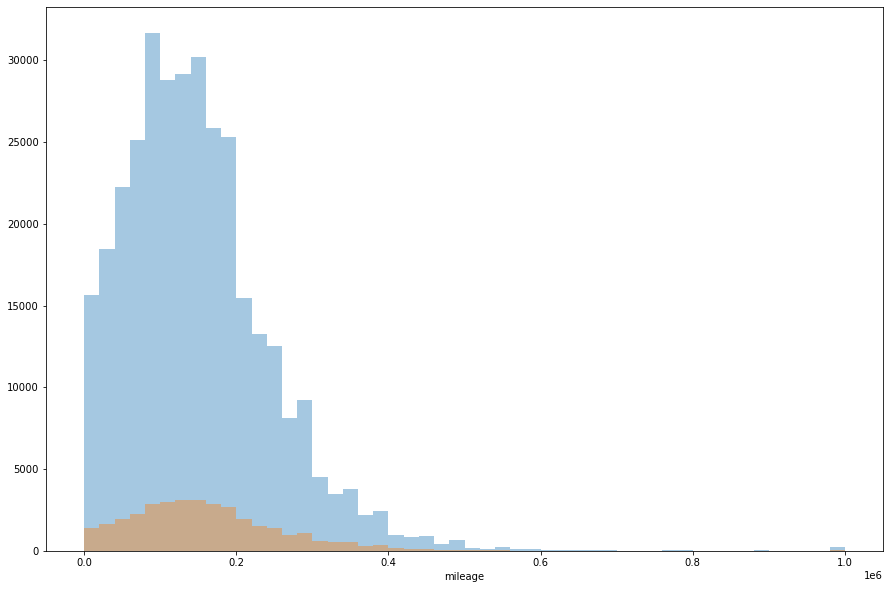

In [75]:
fig, axes = plt.subplots(figsize=(15,10))

sns.distplot(train['mileage'], kde=False)
sns.distplot(test['mileage'], kde=False)
#Распределение нормальное, может быть логарифмирую его попозже

In [76]:
new_train['mileage']=train.mileage

## Колонка modelDate или  generation

In [77]:
test=test.rename({'modelDate': 'generation'}, axis=1)

In [78]:
test=test.drop(columns=['generation'])
train=train.drop(columns=['generation'])

## Колонка model_info

In [79]:
test=test.drop(columns=['model_info'])

## Колонка model_name или model

In [80]:
test=test.rename({'model_name': 'model'}, axis=1)

In [81]:
model_name=[]
for model in train.model:
    model_name.append(model.lower())
train.model=model_name

In [82]:
model_name=[]
for model in test.model:
    model_name.append(model.lower())
test.model=model_name

In [83]:
dummies.append('model')
new_train['model']=train.model

## Колонка name

In [84]:
test=test.drop(columns=['name'])

## numberOfDoors

In [85]:
test=test.rename({'numberOfDoors': 'doors'}, axis=1)

In [86]:
doors=[]
for body in train.body_type:
    if body == 'седан':
        doors.append(5)
    elif body == 'внедорожник 5 дв.':
        doors.append(5)
    elif body == 'хэтчбек 5 дв.':
        doors.append(5)
    elif body == 'универсал 5 дв.':
        doors.append(5)
    elif body == 'лифтбек':
        doors.append(5)
    elif body == 'минивэн':
        doors.append(5)
    elif body == 'компактвэн':
        doors.append(5)
    elif body == 'внедорожник 3 дв.':
        doors.append(3)
    elif body == 'хэтчбек 3 дв.':
        doors.append(3)
    elif body == 'купе':
        doors.append(3)
    elif body == 'пикап двойная кабина':
        doors.append(4)
    elif body == 'фургон':
        doors.append(4)
    elif body == 'внедорожник открытый':
        doors.append(3)
    elif body == 'кабриолет':
        doors.append(3)
    elif body == 'купе-хардтоп':
        doors.append(3)
    elif body == 'седан 2 дв.':
        doors.append(2)
    elif body == 'седан-хардтоп':
        doors.append(5)
    elif body == 'родстер':
        doors.append(3)
    elif body == 'микровэн':
        doors.append(5)
    elif body == 'фастбек':
        doors.append(5)
    elif body == 'пикап полуторная кабина':
        doors.append(2)
    elif body == 'пикап одинарная кабина':
        doors.append(2)
    elif body == 'хэтчбек 4 дв.':
        doors.append(4)
    elif body == 'лимузин':
        doors.append(5)
    elif body == 'тарга':
        doors.append(3)
    elif body == 'спидстер':
        doors.append(2)
    elif body == 'универсал 3 дв.':
        doors.append(3)
    elif body == 'фаэтон':
        doors.append(4)
train['doors']=doors

In [87]:
dummies.append('doors')
new_train['doors']=train['doors']

## Колонка parsing_unixtime

In [88]:
train['parsing_unixtime']=1615975200
new_train['parsing_unixtime']=1615975200

In [89]:
train['parsing_unixtime'].value_counts().count()

1

In [90]:
train['parsing_unixtime'] = pd.to_datetime(train['parsing_unixtime'],unit='s')
test['parsing_unixtime'] = pd.to_datetime(test['parsing_unixtime'],unit='s')

In [91]:
test['parsing_unixtime'].value_counts()

2020-10-19 17:12:07    1
2020-10-21 12:36:49    1
2020-10-21 05:09:36    1
2020-10-26 03:40:13    1
2020-10-21 07:37:02    1
                      ..
2020-10-20 18:59:39    1
2020-10-19 17:20:40    1
2020-10-19 13:40:51    1
2020-10-24 19:31:16    1
2020-10-21 10:44:35    1
Name: parsing_unixtime, Length: 34686, dtype: int64

## Колонка priceCurrency

In [92]:
test=test.drop(columns=['priceCurrency'])

## Колонка productionDate или year

In [93]:
test=test.rename({'productionDate': 'year'}, axis=1)

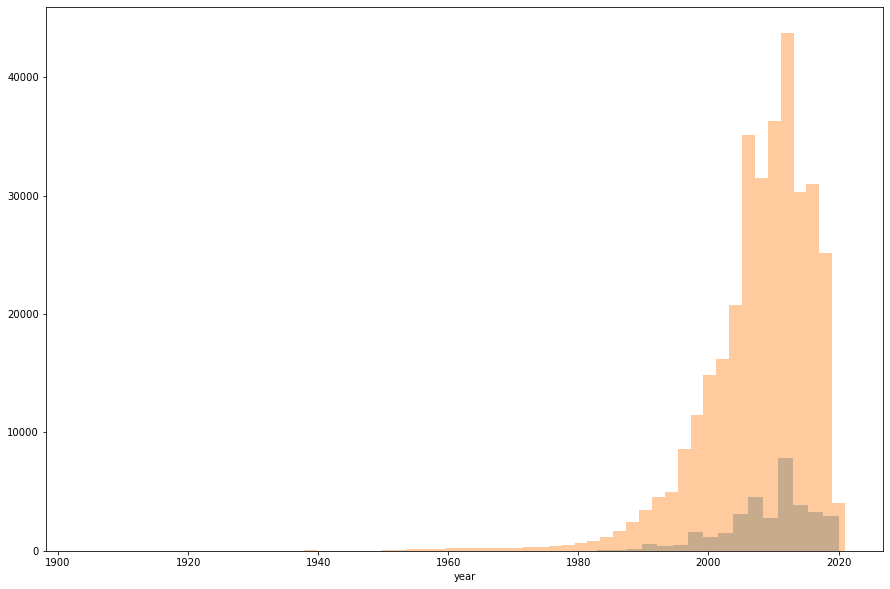

In [94]:
fig, axes = plt.subplots(figsize=(15,10))

sns.distplot(test['year'], kde=False)
sns.distplot(train['year'], kde=False)
#Распределение нормальное, может быть логарифмирую его попозже

new_train['year']=train.year

## Колонка sell_id или date_posted

In [95]:
train=train.drop(columns=['date_posted'])

In [96]:
train=train.drop(columns=['offer_id'])

##  Колонка super_gen

In [97]:
test.super_gen[0]

'{"id":"10373605","displacement":1197,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"ROBOT","power":105,"power_kvt":77,"human_name":"1.2 AMT (105 л.с.)","acceleration":10.5,"clearance_min":155,"fuel_rate":5}'

In [98]:
test=test.drop(columns=['super_gen'])

## Колонки vehicleConfiguration,vehicleTransmission и transmission

In [99]:
test=test.drop(columns=['vehicleConfiguration'])

In [100]:
test=test.rename({'vehicleTransmission': 'transmission'}, axis=1)

In [101]:
test.transmission.isna().value_counts()
#Пропусков нет, супер

False    34686
Name: transmission, dtype: int64

In [102]:
train.transmission.isna().value_counts()
#Тоже пропусков нет, сделаем из этой переменной dummies

False    332647
Name: transmission, dtype: int64

In [103]:
dummies.append('transmission')
new_train['transmission']=train.transmission

## Колонка vendor

In [104]:
test.loc[test.vendor == 'JAPANESE','vendor']='ASIA'

In [105]:
test.vendor.value_counts()

EUROPEAN    20682
ASIA        14004
Name: vendor, dtype: int64

In [106]:
train=train.dropna(subset=['vin'],axis=0)

In [107]:
import re
vendors=[]
for vin in train.vin:
    if re.search("^[A-H]", vin):
        vendors.append('AFRICA')
    elif re.search("^[J-R]", vin):
        vendors.append('ASIA')
    elif re.search("^[S-Z]", vin):
        vendors.append('EUROPEAN')
    elif re.search("^[1-5]", vin):
        vendors.append('NORTH AMERICA')
    elif re.search("^[6-7]", vin):
        vendors.append('OCEANIA')
    elif re.search("^[8-9]", vin):
        vendors.append('SOUTH AMERICA')
    else:
        vendors.append('Invalid vin')
        

In [108]:
train['vendor']=vendors

In [109]:
train=train.drop(columns=['vin'])
dummies.append('vendor')

# Владельцы или owners_count

In [110]:
test=test.rename({'Владельцы': 'owners_count'}, axis=1)

In [111]:
test.owners_count.value_counts()

3 или более    15957
1 владелец      9459
2 владельца     9270
Name: owners_count, dtype: int64

In [112]:
import re
nums=[]

for owner in test.owners_count:
    num=(re.findall(r'\d+', owner))
    for n in num:
        nums.append(float(n))
test.owners_count=nums


In [113]:
test.owners_count

0        3.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
34681    3.0
34682    1.0
34683    3.0
34684    2.0
34685    3.0
Name: owners_count, Length: 34686, dtype: float64

In [114]:
#В трейне 31 пустое значение, их не восстановишь, просто удалим
train=train.dropna(subset=['owners_count'],axis=0)
train.owners_count.isna().value_counts()

False    323879
Name: owners_count, dtype: int64

## Владение

In [115]:
test.Владение.isna().value_counts()

True     22691
False    11995
Name: Владение, dtype: int64

In [116]:
test[(test.Владение.isna() == True) & (test.owners_count == 1)]

body_type  brand  \
1                лифтбек      8   
2                лифтбек      8   
3                лифтбек      8   
4                лифтбек      8   
6      внедорожник 5 дв.      8   
...                  ...    ...   
34649  внедорожник 5 дв.      1   
34651  внедорожник 5 дв.      1   
34671              седан      1   
34673              седан      1   
34682              седан      1   

                                                 car_url       color  \
1      https://auto.ru/cars/used/sale/skoda/octavia/1...      чёрный   
2      https://auto.ru/cars/used/sale/skoda/superb/11...       серый   
3      https://auto.ru/cars/used/sale/skoda/octavia/1...  коричневый   
4      https://auto.ru/cars/used/sale/skoda/octavia/1...       белый   
6      https://auto.ru/cars/used/sale/skoda/yeti/1101...   пурпурный   
...                                                  ...         ...   
34649  https://auto.ru/cars/used/sale/bmw/x1/11013719...       белый   
34651  https://auto.ru/cars/used/sale/bmw/x5/11013720...      чёрный   
34671  https://auto.ru/cars/used/sale/bmw/3er/1101369...       серый   
34673  https://auto.ru/cars/used/sale/bmw/7er/1101370...      чёрный   
34682  https://auto.ru/cars/used/sale/bmw/5er/1101369...      чёрный   

                                           complectation  engine_volume  \
1      ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...            1.6   
2      Все автомобили, представленные в продаже, прох...            1.8   
3      КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...            1.6   
4      ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...            1.8   
6      - выгода 60 000 рублей при покупке авто в Trad...            1.8   
...                                                  ...            ...   
34649  Автомобиль в отличном состоянии, дизель, небол...            2.0   
34651  Автомобиль дилерский на гарантии один хозяин б...            3.0   
34671  Продаю свой автомобиль.\nЧистокровный баварец....            2.0   
34673  BMW 7 long полный комплектация Машина в идеаль...            4.8   
34682                     Продаётся отличный автомобиль.            2.0   

       engine_power fuel_type  mileage    model  ...  Регулировка руля  \
1             110.0    бензин    60563  octavia  ...                 1   
2             152.0    бензин    88000   superb  ...                 0   
3             110.0    бензин    95000  octavia  ...                 0   
4             152.0    бензин    58536  octavia  ...                 1   
6             152.0    бензин   107000     yeti  ...                 0   
...             ...       ...      ...      ...  ...               ...   
34649         184.0    дизель    82700       x1  ...                 0   
34651         313.0    дизель    65000       x5  ...                 0   
34671         143.0    дизель   160000      3er  ...                 0   
34673         367.0    бензин   239000      7er  ...                 0   
34682         190.0    дизель    98000      5er  ...                 0   

      Аудиоподготовка  дисков  Подогрев сидений Кредитование  \
1                   0       0                 0            0   
2                   0       0                 0            0   
3                   0       0                 0            0   
4                   0       0                 0            0   
6                   0       0                 0            0   
...               ...     ...               ...          ...   
34649               0       0                 0            0   
34651               0       0                 0            0   
34671               0       0                 0            0   
34673               0       0                 0            0   
34682               0       0                 0            0   

      Срочный выкуп Вашего автомобиля  Первоначальный взнос от 0%;  \
1                                   0                            0   
2                             

In [117]:
test=test.drop(columns=['Владение'])

## ПТС или pts 

In [118]:
test.ПТС.isna().value_counts()
#Закрался один пропуск, давайте заменим его на наиболее частое значение

False    34686
Name: ПТС, dtype: int64

In [119]:
test.loc[test.ПТС.isna()== True,'ПТС']='Оригинал'

In [120]:
test=test.rename({'ПТС': 'pts'}, axis=1)

In [121]:
train.pts.isna().value_counts()
#Тут тоже 6 пропусков, выбросим их, не будем морочиться

False    323873
True          6
Name: pts, dtype: int64

In [122]:
train=train.dropna(subset=['pts'],axis=0)

In [123]:
train.pts.dtype.kind

'O'

In [124]:
dummies.append('pts')

## Колонка Привод или  drive

In [125]:
test=test.rename({'Привод': 'drive'}, axis=1)

In [126]:
test.drive.isna().value_counts()
#пропусков нет

False    34686
Name: drive, dtype: int64

In [127]:
test.drive.value_counts()

передний    15565
полный      15020
задний       4101
Name: drive, dtype: int64

In [128]:
train.drive.isna().value_counts()
#тут тоже пропусков нет, названия одинаковые, мне нравится, сделаем позднее Dummies

False    323873
Name: drive, dtype: int64

In [129]:
dummies.append('drive')

## Руль или wheel

In [130]:
test=test.rename({'Руль': 'wheel'}, axis=1)

In [131]:
test.wheel.value_counts()

Левый     33287
Правый     1399
Name: wheel, dtype: int64

In [132]:
train.wheel.isna().value_counts()

False    323873
Name: wheel, dtype: int64

In [133]:
dummies.append('wheel')

## Cостояние или state

In [134]:
test=test.rename({'Состояние': 'state'}, axis=1)

In [135]:
test.state.value_counts()

Не требует ремонта    34686
Name: state, dtype: int64

In [136]:
train.state.value_counts()

Не требует ремонта    323866
Битый / не на ходу         7
Name: state, dtype: int64

In [137]:
dummies.append('state')

## Таможня или customs

In [138]:
test=test.rename({'Таможня': 'customs'}, axis=1)

In [139]:
test.customs.isna().value_counts()

False    34686
Name: customs, dtype: int64

In [140]:
train.customs.value_counts()

Растаможен       320504
Не растаможен      3369
Name: customs, dtype: int64

In [141]:
dummies.append('customs')

## Колонка url или car_url               

In [142]:
test=test.drop(columns=['car_url'])
train=train.drop(columns=['catalog_link'])
train=train.drop(columns=['orig_url'])

In [143]:
train=train.drop(columns=['url'])

## views_total и views_today, license_plate 

In [144]:
train=train.drop(columns=['views_total'])
train=train.drop(columns=['views_today'])
train=train.drop(columns=['license_plate'])

## Exchange

In [145]:
train=train.drop(columns=['exchange'])

# Price

In [146]:
train.price.isna().value_counts()
#Удалим все пустые значения и посмотрим на распределенеи

False    322162
True       1711
Name: price, dtype: int64

In [147]:
train=train.dropna(subset=['price'],axis=0)

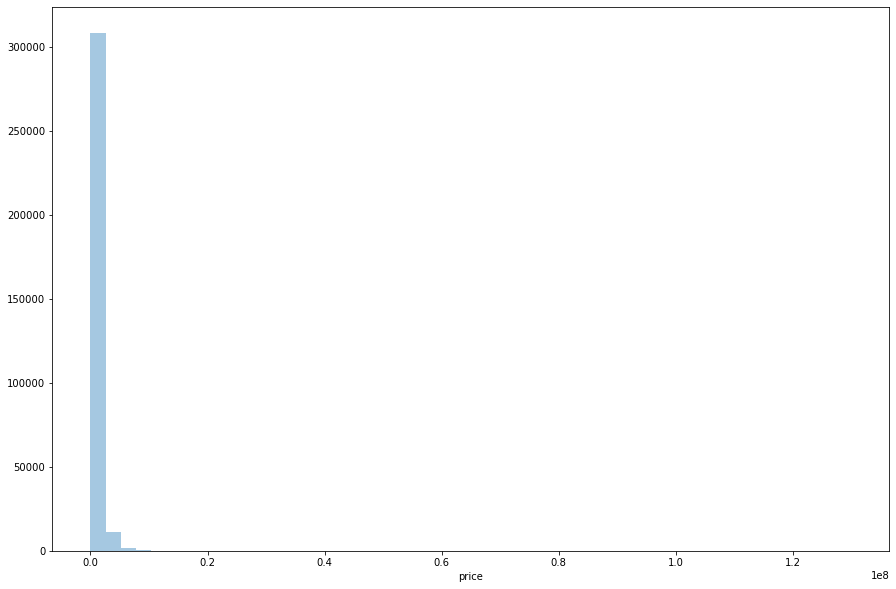

In [148]:
fig, axes = plt.subplots(figsize=(15,10))

sns.distplot(train['price'], kde=False)

In [149]:
test=test.drop(columns=['complectation'])
train=train.drop(columns=['complectation'])

In [150]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322162 entries, 0 to 332675
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   brand              322162 non-null  int64         
 1   model              322162 non-null  object        
 2   year               322162 non-null  float64       
 3   mileage            322162 non-null  float64       
 4   body_type          322162 non-null  object        
 5   color              322162 non-null  object        
 6   fuel_type          322162 non-null  object        
 7   engine_volume      322162 non-null  float64       
 8   engine_power       322162 non-null  float64       
 9   transmission       322162 non-null  object        
 10  drive              322162 non-null  object        
 11  wheel              322162 non-null  object        
 12  state              322162 non-null  object        
 13  owners_count       322162 non-null  float64 

In [151]:
new_train['vendor']=train['vendor']
new_train['owners_count']=train['owners_count']
new_train['pts']=train['pts']
new_train['drive']=train['drive']
new_train['wheel']=train['wheel']
new_train['state']=train['state']
new_train['customs']=train['customs']
new_train['complectation_len']=train['complectation_len']
new_train['key_list']=train['key_list']
new_train['price']=train['price']

In [152]:
new_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 332647 entries, 0 to 332675
Data columns (total 73 columns):
 #   Column                                               Non-Null Count   Dtype  
---  ------                                               --------------   -----  
 0   body_type                                            332647 non-null  object 
 1   brand                                                332647 non-null  int64  
 2   color                                                332647 non-null  object 
 3   key_list                                             322162 non-null  object 
 4   Центральный замок                                    332647 non-null  int64  
 5   Антиблокировочная система                            332647 non-null  int64  
 6   Бортовой компьютер                                   332647 non-null  int64  
 7   Электропривод зеркал                                 332647 non-null  int64  
 8   Обогрев зеркал                                       3

# Преобразование бинарных и категориальных переменных

In [153]:
label_encoder = LabelEncoder()

lb_cat=['brand','body_type','color','fuel_type','pts','wheel','state','customs','vendor','transmission','drive']

for column in lb_cat:
    new_train[column] = label_encoder.fit_transform(new_train[column].astype(str))
    test[column] = label_encoder.fit_transform(test[column].astype(str))

    
# убедимся в преобразовании    
display(new_train.head())
display(test.head())

body_type  brand  color                                           key_list  \
0         27      7     12                                           [Noinfo]   
1         15      0      0                                           [Noinfo]   
2         15      0     13         [Центральный замок, Кондиционер, AUX, USB]   
3         15      0     15  [Центральный замок, Антиблокировочная система,...   
4         15      0     13                                                 []   

   Центральный замок  Антиблокировочная система  Бортовой компьютер  \
0                  0                          0                   0   
1                  0                          0                   0   
2                  1                          0                   0   
3                  1                          1                   1   
4                  0                          0                   0   

   Электропривод зеркал  Обогрев зеркал  CD  ...  transmission  vendor  \
0                     0               0   0  ...             0       2   
1                     0               0   0  ...             2       2   
2                     0               0   0  ...             2       1   
3                     0               0   0  ...             2       2   
4                     0               0   0  ...             2       2   

   owners_count  pts  drive  wheel  state  customs  complectation_len  \
0           2.0    2      2      2      2        2                0.0   
1           2.0    2      1      1      2        2                0.0   
2           3.0    2      2      1      2        2              210.0   
3           2.0    2      2      1      2        2              475.0   
4           1.0    2      2      1      2        2               23.0   

      price  
0  230000.0  
1   35000.0  
2   45000.0  
3  475000.0  
4  479000.0  

[5 rows x 73 columns]

body_type  brand  color  engine_volume  engine_power  fuel_type  mileage  \
0          8     10     13            1.2         105.0          0    74000   
1          8     10     15            1.6         110.0          0    60563   
2          8     10     12            1.8         152.0          0    88000   
3          8     10      6            1.6         110.0          0    95000   
4          8     10      1            1.8         152.0          0    58536   

     model  doors    parsing_unixtime  ...  Регулировка руля  Аудиоподготовка  \
0  octavia      5 2020-10-20 20:37:53  ...                 0                0   
1  octavia      5 2020-10-20 20:37:57  ...                 1                0   
2   superb      5 2020-10-20 20:38:00  ...                 0                0   
3  octavia      5 2020-10-20 20:38:04  ...                 0                0   
4  octavia      5 2020-10-20 20:38:08  ...                 1                0   

   дисков  Подогрев сидений  Кредитование  Срочный выкуп Вашего автомобиля  \
0       0                 0             0                                0   
1       0                 0             0                                0   
2       0                 0             0                                0   
3       0                 0             0                                0   
4       0                 0             0                                0   

   Первоначальный взнос от 0%;  Третий задний подголовник  Усилитель руля  \
0                            1                          0               0   
1                            0                          0               1   
2                            1                          0               0   
3                            1                          0               0   
4                            0                          0               1   

   Noinfo  
0       0  
1       0  
2       0  
3       0  
4       0  

[5 rows x 72 columns]

In [154]:
num_cols=['engine_volume','engine_power','mileage','doors','parsing_unixtime','year','owners_count','complectation_len']
price=['price']

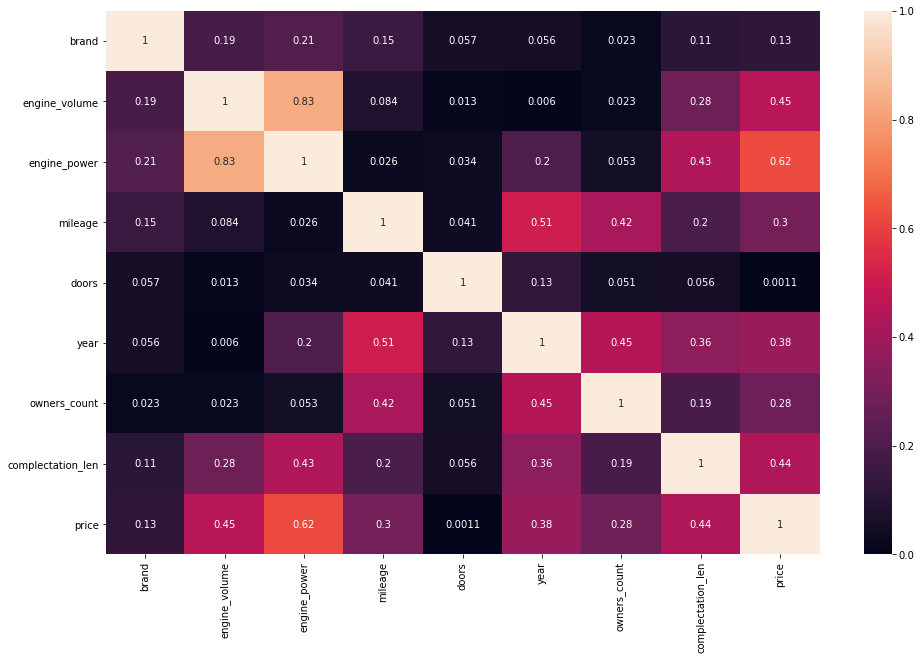

In [155]:
plt.figure(figsize=(16,10))
sns.heatmap(train[lb_cat+num_cols+price].corr().abs(), vmin=0, vmax=1, annot=True)

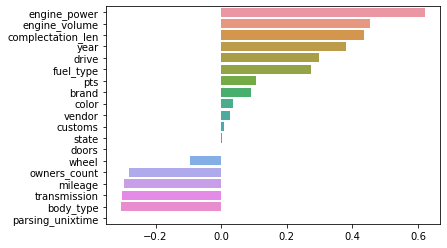

In [156]:
correlations = new_train[lb_cat+num_cols].corrwith(new_train['price']).sort_values(ascending=False)

plot = sns.barplot(y=correlations.index, x=correlations,capsize=2)
#График выглядит не очень посмотрим так

In [157]:
correlations


engine_power         0.621778
engine_volume        0.453961
complectation_len    0.436522
year                 0.381768
drive                0.297164
fuel_type            0.272790
pts                  0.105028
brand                0.092063
color                0.037392
vendor               0.025432
customs              0.007361
state                0.001515
doors               -0.001144
wheel               -0.094452
owners_count        -0.281425
mileage             -0.296888
transmission        -0.301614
body_type           -0.305971
parsing_unixtime          NaN
dtype: float64

In [158]:
correlations = new_train[k_list].corrwith(new_train['price']).sort_values(ascending=False)
correlations

Датчик дождя                                           0.384459
Датчик света                                           0.378347
Мультифункциональное рулевое колесо                    0.357445
Bluetooth                                              0.325116
Круиз-контроль                                         0.311569
Бортовой компьютер                                     0.300146
Передний центральный подлокотник                       0.285340
Антипробуксовочная система                             0.279086
Электропривод зеркал                                   0.275288
Антиблокировочная система                              0.272268
USB                                                    0.262694
Иммобилайзер                                           0.261167
Розетка 12V                                            0.252802
Третий задний подголовник                              0.247837
AUX                                                    0.236743
Центральный замок                       

In [159]:
new_train=new_train.dropna(axis=0)

In [160]:
new_train

body_type  brand  color  \
0              27      7     12   
1              15      0      0   
2              15      0     13   
3              15      0     15   
4              15      0     13   
...           ...    ...    ...   
332671          1      0      9   
332672          1      1     15   
332673          1      6     13   
332674         15      0      1   
332675         21      0     12   

                                                 key_list  Центральный замок  \
0                                                [Noinfo]                  0   
1                                                [Noinfo]                  0   
2              [Центральный замок, Кондиционер, AUX, USB]                  1   
3       [Центральный замок, Антиблокировочная система,...                  1   
4                                                      []                  0   
...                                                   ...                ...   
332671  [Центральный замок, Антиблокировочная система,...                  1   
332672  [Центральный замок, Антиблокировочная система,...                  1   
332673  [Центральный замок, Антиблокировочная система,...                  1   
332674  [Центральный замок, Антиблокировочная система,...                  1   
332675  [Антиблокировочная система, Электропривод зерк...                  0   

        Антиблокировочная система  Бортовой компьютер  Электропривод зеркал  \
0                               0                   0                     0   
1                               0                   0                     0   
2                               0                   0                     0   
3                               1                   1                     0   
4                               0                   0                     0   
...                           ...                 ...                   ...   
332671                          1                   0                     1   
332672                          1                   1                     1   
332673                          1                   1                     1   
332674                          1                   1                     1   
332675                          1                   0                     1   

        Обогрев зеркал  CD  ...  transmission  vendor  owners_count  pts  \
0                    0   0  ...             0       2           2.0    2   
1                    0   0  ...             2       2           2.0    2   
2                    0   0  ...             2       1           3.0    2   
3                    0   0  ...             2       2           2.0    2   
4                    0   0  ...             2       2           1.0    2   
...                ...  ..  ...           ...     ...           ...  ...   
332671               0   0  ...             0       1           3.0    2   
332672               0   0  ...             3       2           1.0    2   
332673               0   0  ...             1       2           2.0    2   
332674               0   0  ...             2       2           1.0    2   
332675               0   0  ...             2       2           1.0    2   

        drive  wheel  state  customs  complectation_len      price  
0           2      2      2        2                0.0   230000.0  
1           1      1      2        2                0.0    35000.0  
2           2      1      2        2              210.0    45000.0  
3           2      1      2        2              475.0   475000.0  
4           2      1      2        2               23.0   479000.0  
...       ...    ...    ...      ...                ...        ...  
332671      3      1      2        2              131.0   160000.0  
332672      2      1      2        2              978.0  2650000.0  
332673      2      1      2        2              702.0  1314000.0  
332674      2      1      2        2              936.0   470000.0  
33267

## Значимость числовых переменных

Text(0.5, 0, 'F-value')

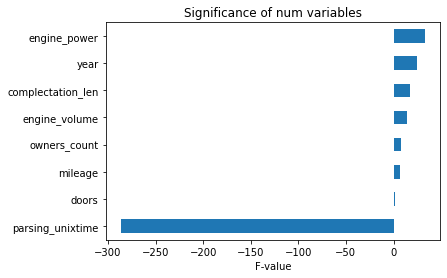

In [161]:
imp_num = Series(f_classif(new_train[num_cols], new_train['price'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')
plt.title('Significance of num variables')
plt.xlabel('F-value')

## Значимость категориальных переменных

Text(0.5, 1.0, 'Significance of bin variables')

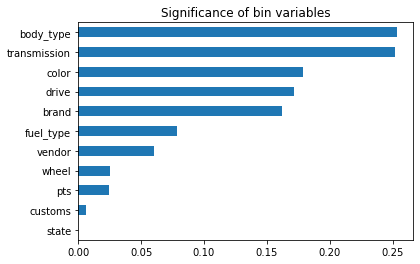

In [162]:
# Значимость категориальных признаков

imp_bin = Series(mutual_info_classif(new_train[lb_cat], new_train['price'],
                                     discrete_features =True), index = lb_cat)
imp_bin.sort_values(inplace = True)
imp_bin.plot(kind = 'barh')
plt.title('Significance of bin variables')

Text(0.5, 1.0, 'Significance of bin variables')

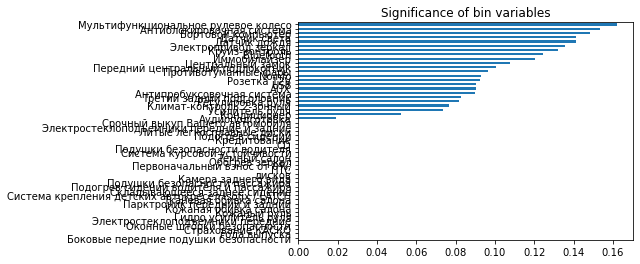

In [163]:
# Значимость бинарных признаков

imp_bin = Series(mutual_info_classif(new_train[k_list], new_train['price'],
                                     discrete_features =True), index = k_list)
imp_bin.sort_values(inplace = True)
imp_bin.plot(kind = 'barh')
plt.title('Significance of bin variables')

In [164]:
imp_bin.sort_values(ascending=False)

Мультифункциональное рулевое колесо                    1.621680e-01
Антиблокировочная система                              1.532757e-01
Бортовой компьютер                                     1.481860e-01
Датчик света                                           1.414670e-01
Датчик дождя                                           1.411575e-01
Электропривод зеркал                                   1.357883e-01
Круиз-контроль                                         1.322422e-01
Bluetooth                                              1.245004e-01
Иммобилайзер                                           1.202533e-01
Центральный замок                                      1.074737e-01
Передний центральный подлокотник                       1.007028e-01
Противотуманные фары                                   9.632973e-02
Noinfo                                                 9.288096e-02
Розетка 12V                                            9.219271e-02
USB                                             

In [165]:
k_list=['Мультифункциональное рулевое колесо',
'Антиблокировочная система',
'Бортовой компьютер',
'Датчик света',
'Датчик дождя',
'Электропривод зеркал',
'Круиз-контроль',
'Bluetooth',
'Иммобилайзер',
'Центральный замок',
'Передний центральный подлокотник',
'Противотуманные фары',
'Noinfo',
'Розетка 12V',
'USB',
'AUX',
'Антипробуксовочная система',
'Третий задний подголовник',
'Регулировка руля',
'Климат-контроль 2-зонный',
'Усилитель руля',
'Кондиционер',
'Аудиоподготовка']

In [166]:
num_cols=['engine_volume','engine_power','mileage','doors','year','owners_count','complectation_len']
#Убрала время парсинга

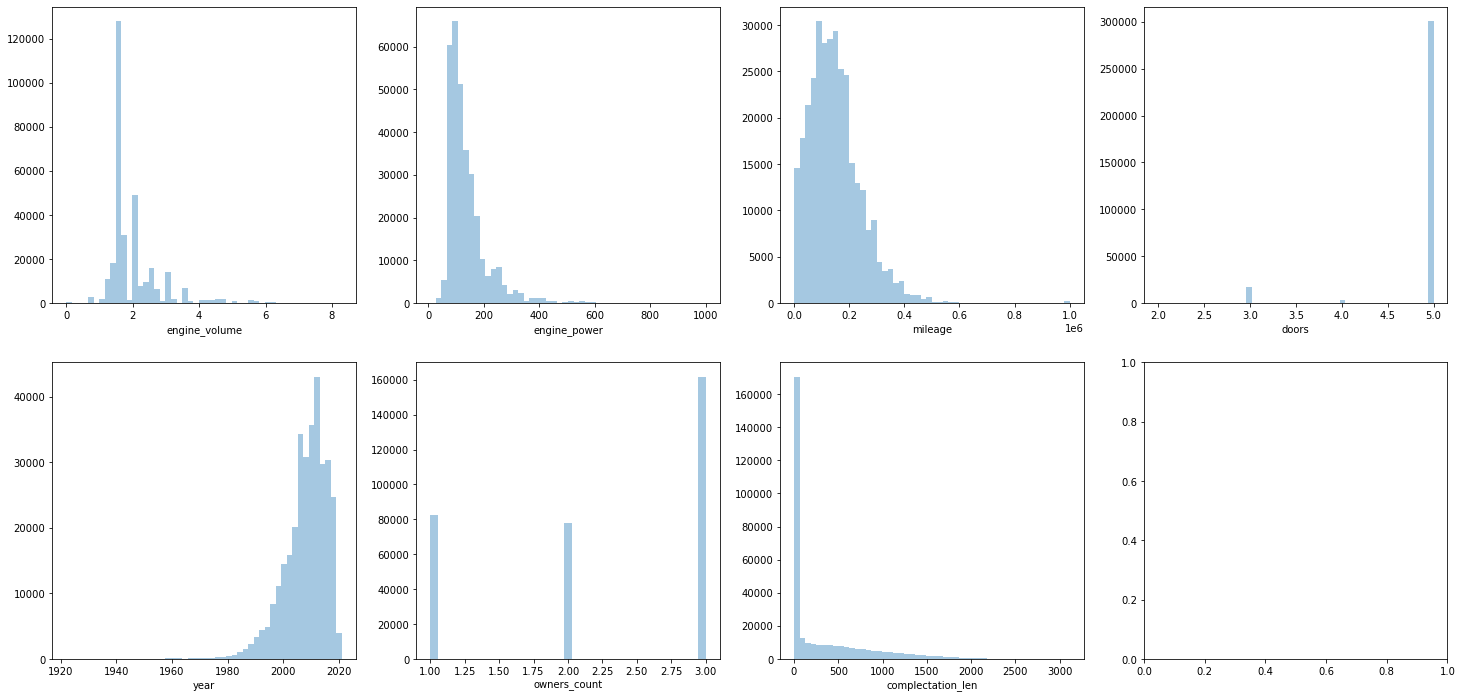

In [167]:
fig, axes = plt.subplots(2, 4, figsize=(25,12))
for col, i in zip(num_cols, range(7)):
    sns.distplot(train[col], kde=False, ax=axes.flat[i])

In [168]:
log_cols=['year','mileage','complectation_len']

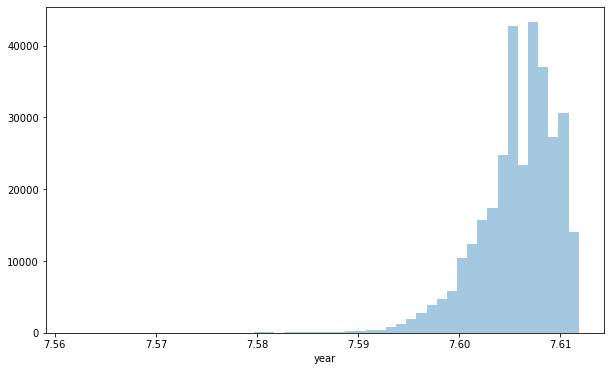

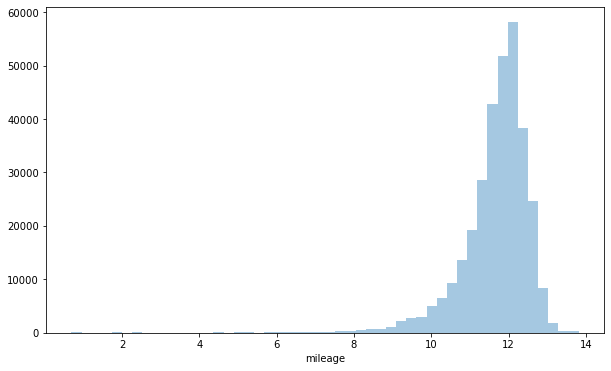

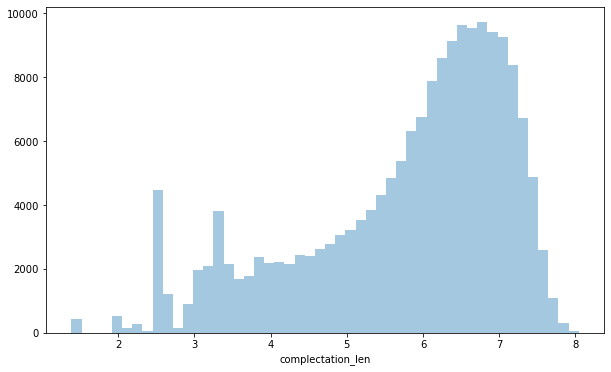

In [169]:
for i in log_cols:
    train[i] = np.log(train[i] + 1)
    plt.figure(figsize=(10,6))
    sns.distplot(train[i][train[i] > 0].dropna(), kde = False, rug=False)
    plt.show()

In [170]:
lb_cat=['brand','body_type','color','fuel_type','pts','wheel','state','customs','vendor','transmission','drive','Мультифункциональное рулевое колесо',
'Антиблокировочная система',
'Бортовой компьютер',
'Датчик света',
'Датчик дождя',
'Электропривод зеркал',
'Круиз-контроль',
'Bluetooth',
'Иммобилайзер',
'Центральный замок',
'Передний центральный подлокотник',
'Противотуманные фары',
'Noinfo',
'Розетка 12V',
'USB',
'AUX',
'Антипробуксовочная система',
'Третий задний подголовник',
'Регулировка руля',
'Климат-контроль 2-зонный',
'Усилитель руля',
'Кондиционер',
'Аудиоподготовка']


In [171]:
test[k_list]

Мультифункциональное рулевое колесо  Антиблокировочная система  \
0                                        0                          0   
1                                        0                          1   
2                                        0                          0   
3                                        0                          0   
4                                        0                          1   
...                                    ...                        ...   
34681                                    0                          0   
34682                                    0                          0   
34683                                    0                          0   
34684                                    0                          0   
34685                                    0                          0   

       Бортовой компьютер  Датчик света  Датчик дождя  Электропривод зеркал  \
0                       0             0             0                     0   
1                       1             1             1                     1   
2                       0             0             0                     0   
3                       0             0             0                     0   
4                       1             1             1                     1   
...                   ...           ...           ...                   ...   
34681                   0             0             0                     0   
34682                   0             0             0                     0   
34683                   0             0             0                     0   
34684                   0             0             0                     0   
34685                   0             0             0                     0   

       Круиз-контроль  Bluetooth  Иммобилайзер  Центральный замок  ...  \
0                   0          0             0                  0  ...   
1                   1          0             1                  1  ...   
2                   0          0             0                  0  ...   
3                   0          0             0                  0  ...   
4                   1          0             1                  1  ...   
...               ...        ...           ...                ...  ...   
34681               0          0             0                  0  ...   
34682               0          0             0                  0  ...   
34683               0          0             0                  0  ...   
34684               0          0             0                  0  ...   
34685               0          0             0                  0  ...   

       Розетка 12V  USB  AUX  Антипробуксовочная система  \
0                0    0    0                           0   
1                0    1    0                           1   
2                0    0    0                           0   
3                0    0    0                           0   
4                0    0    0                           1   
...            ...  ...  ...                         ...   
34681            0    0    0                           0   
34682            0    0    0                           0   
34683            0    0    0                           0   
34684            0    0    0                           0   
34685            0    0    0                           0   

       Третий задний подголовник  Регулировка руля  Климат-контроль 2-зонный  \
0                              0                 0                         0   
1                              0                 1                         0   
2                              0                 0                         0   
3                              0                 0                         0   
4                              0                 1                         0   
...                          ...               ...                       ...   
34681      

# Подготовка данных к машинному обучению

In [172]:
x_num = StandardScaler().fit_transform(new_train[num_cols].values)
y_num = StandardScaler().fit_transform(test[num_cols].values)

In [173]:
X = np.hstack([x_num, new_train[lb_cat].values])
y = new_train['price'].values

id_test = test.sell_id
test = np.hstack([y_num, test[lb_cat].values])

## Train Split

In [174]:
RANDOM_SEED = 42

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=RANDOM_SEED)

In [176]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [177]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [178]:
mape(y_test, y_pred)

0.9362375856459451

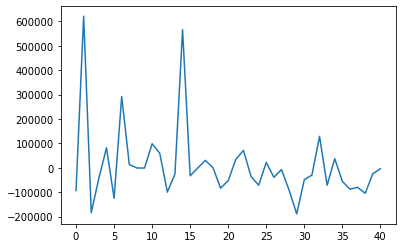

In [179]:
plt.plot(lr.coef_)

## 2.1.1. RIDGE regression

In [180]:
ridge = Ridge(random_state=RANDOM_SEED)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
mape(y_test, y_pred)

0.9362290653890252

Best alpha = 54.6228


Text(0, 0.5, 'CV score')

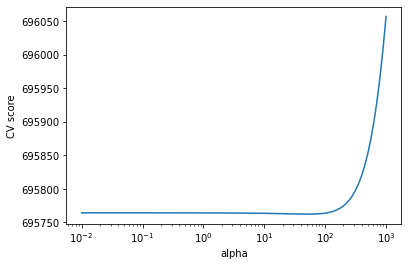

In [181]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 3, 100)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)
searcher.fit(X_train, y_train)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [182]:
from sklearn.linear_model import LassoCV, RidgeCV
ridge_alphas = np.logspace(-2, 3, 200)
ridge_cv = RidgeCV(alphas=ridge_alphas, 
                   scoring='neg_mean_squared_error',
                   cv=10)
ridge_cv.fit(X_train, y_train)

print("alpha = %.4f" % ridge_cv.alpha_)

alpha = 13.8262


In [183]:
search_grid_lr = {
    'alpha':[12.3155],
    'max_iter': [100, 1000, 10000],
}

In [184]:
gridsearch_lr = GridSearchCV(estimator = ridge, 
                             param_grid = search_grid_lr, 
                             scoring='neg_mean_squared_error', 
                             n_jobs=-1, 
                             verbose = 2)
gridsearch_lr.fit(X_train, y_train)
best_lr = gridsearch_lr.best_estimator_
print(best_lr)
best_lr.fit(X_train, y_train)
y_pred = best_lr.predict(X_test)
mape(y_test, y_pred)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    1.5s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.8s finished


Ridge(alpha=12.3155, max_iter=100, random_state=42)


0.9361382710292008

# Random forest

In [185]:
rf = RandomForestRegressor(random_state = RANDOM_SEED, n_jobs=-1, verbose = False)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mape(y_test, y_pred)

0.19905772994032053

## CatBoost

In [186]:
cr = CatBoostRegressor(logging_level = 'Silent', 
                       task_type="CPU", 
                       random_seed=RANDOM_SEED)
cr.fit(X_train, y_train)
y_pred = cr.predict(X_test)
mape(y_test, y_pred)

0.23434137692850102

In [187]:
cr_params =  {"iterations": [1000, 2000],
              "depth": [4,8]}
gridsearch_cat = GridSearchCV(estimator = cr, param_grid = cr_params, n_jobs=-1)
gridsearch_cat.fit(X_train, y_train)
best_cat = gridsearch_cat.best_estimator_
print(best_cat.get_params())

{'iterations': 2000, 'depth': 8, 'loss_function': 'RMSE', 'random_seed': 42, 'logging_level': 'Silent', 'task_type': 'CPU'}


In [188]:
best_cat.fit(X_train, y_train)
y_pred = best_cat.predict(X_test)
mape(y_test, y_pred)

0.21402454577689276

## Решающие деревья

In [189]:
treereg = DecisionTreeRegressor(random_state=RANDOM_SEED)
treereg.fit(X_train, y_train)
y_pred = treereg.predict(X_test)
mape(y_test, y_pred)

0.25934096499122966

In [190]:
tree_params =  {'max_features': ['auto', 'sqrt', 'log2'],
               'min_samples_split': [5, 10, 25, 50, 75, 100, 200],
               'max_depth': [10,20,50]}
gridsearch_tree = GridSearchCV(estimator = treereg, param_grid = tree_params, n_jobs=-1)
gridsearch_tree.fit(X_train, y_train)
best_tree = gridsearch_tree.best_estimator_
best_tree.fit(X_train, y_train)
y_pred = best_tree.predict(X_test)
print(best_tree)
mape(y_test, y_pred)

DecisionTreeRegressor(max_depth=20, max_features='auto', min_samples_split=25,
                      random_state=42)


0.21532344267776354

## Бэггинг

In [191]:
bagger_tree = BaggingRegressor(base_estimator=best_tree)
bagger_tree.fit(X_train, y_train)
y_pred = bagger_tree.predict(X_test)
mape(y_test, y_pred)

0.20174866685142814

In [192]:
bag_params =  {'n_estimators': [10, 50, 100],
              'max_samples': [0.5, 0.75, 1.0],
               'max_features': [0.5, 0.75, 1.0]}
gridsearch_bag = GridSearchCV(estimator = bagger_tree, param_grid = bag_params, n_jobs=-1)
gridsearch_bag.fit(X_train, y_train)
best_bag_tree = gridsearch_bag.best_estimator_
best_bag_tree.fit(X_train, y_train)
y_pred = best_bag_tree.predict(X_test)
print(best_bag_tree)

BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=20,
                                                      max_features='auto',
                                                      min_samples_split=25,
                                                      random_state=42),
                 max_features=0.75, n_estimators=100)


In [193]:
mape(y_test, y_pred)

0.22131427481750746

По результатам метрики выбираем рандомные деревья.
В целом, результат на обучающей выборке лучше, чем на тесте.


In [228]:
y_pred = rf.predict(test)
y_pred=y_pred*1.119
#Умножим предсказания на фактор инфляции, чотбы скомпенсировать ее, так как данные были собраны в разное время, за это время
#рубль беспощадно упал, рынок в целом поменялся. Я пыталась попроавить этот момент за счет переменной parcing_time, но F-метрика
# была неадекватная, поэтому я удалила этот параметр.


In [229]:
my_submission = pd.DataFrame({'sell_id': id_test, 
                            'price': y_pred})
my_submission.to_csv('submission.csv', index=False)

my_submission

sell_id         price
0      1100575026  4.919572e+05
1      1100549428  9.484409e+05
2      1100658222  8.426294e+05
3      1100937408  5.662028e+05
4      1101037972  8.133228e+05
...           ...           ...
34681  1101369263  3.381268e+05
34682  1101369581  1.522789e+06
34683  1101364889  2.367244e+05
34684  1101362518  1.132183e+06
34685  1101256068  7.013668e+05

[34686 rows x 2 columns]